In [21]:
import pyxdf
import numpy as np
streams, header = pyxdf.load_xdf("sub-P001_ses-S001_task-Default_run-001_eeg.xdf")
# streams, header = pyxdf.load_xdf("C:/Users/Toey/Desktop/data_ssvep/Toey/exp1/block_2.xdf")


In [22]:
streams

[{'info': defaultdict(list,
              {'name': ['obci_eeg1'],
               'type': ['EEG'],
               'channel_count': ['8'],
               'nominal_srate': ['250'],
               'channel_format': ['float32'],
               'source_id': ['openbcigui'],
               'version': ['1.1000000000000001'],
               'created_at': ['251807.712623625'],
               'uid': ['fcc965da-edc3-458c-a74a-a24b7abce9ab'],
               'session_id': ['default'],
               'hostname': ['Phoebes-MacBook-Air.local'],
               'v4address': [None],
               'v4data_port': ['16572'],
               'v4service_port': ['16572'],
               'v6address': [None],
               'v6data_port': ['0'],
               'v6service_port': ['0'],
               'desc': [None],
               'stream_id': 1,
               'effective_srate': 249.98974951485263}),
  'footer': {'info': defaultdict(list,
               {'first_timestamp': ['252092.563774375'],
                'la

In [23]:
raw_data = streams[0]['time_series'].T

In [24]:
raw_data.shape

(8, 3260)

# Process & Visualize data using MNE
https://mne.tools/stable/auto_tutorials/index.html

In [25]:
import mne

In [26]:
# Create info and raw data variable required by mne
chans =['FP1','FP2','C3','C4','T5','T6','O1','O2']
info_mne = mne.create_info(ch_names = chans, sfreq=250, ch_types=['eeg']*len(chans))
raw_mne = mne.io.RawArray(raw_data,info_mne)


Creating RawArray with float64 data, n_channels=8, n_times=3260
    Range : 0 ... 3259 =      0.000 ...    13.036 secs
Ready.


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


C:\Users\Toey\AppData\Local\Temp\ipykernel_31320\1614822015.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_mne.plot_psd()
C:\Users\Toey\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


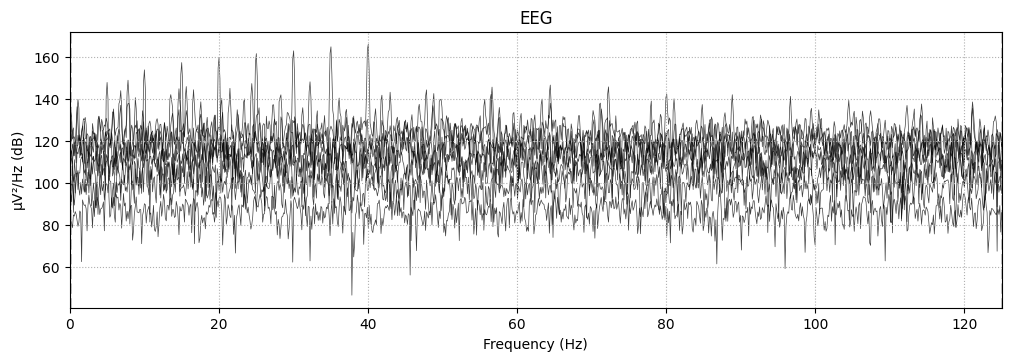

In [27]:
# Create psd plot
pick = ['O1', 'O2']
raw_mne.
raw_mne.plot_psd()

In [28]:
low_freq = 8.0
high_freq = 12.0
raw_mne_filtered = raw_mne.copy().filter(l_freq=low_freq,h_freq=high_freq)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 413 samples (1.652 s)



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


C:\Users\Toey\AppData\Local\Temp\ipykernel_31320\2242267490.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_mne_filtered.plot_psd()
C:\Users\Toey\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


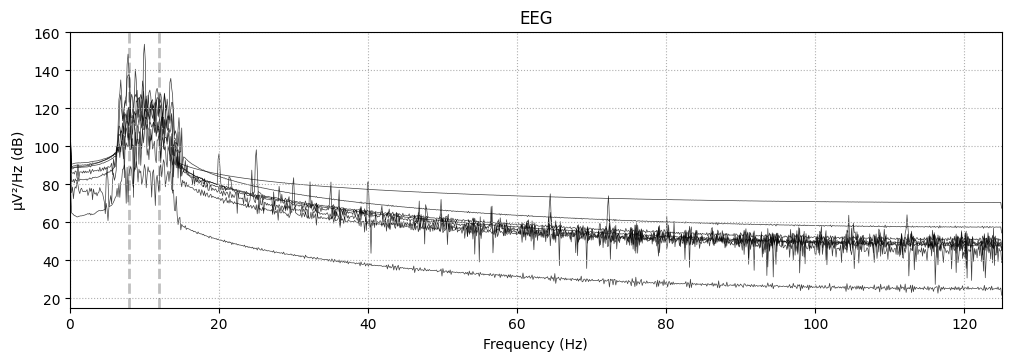

In [29]:
raw_mne_filtered.plot_psd()

In [30]:
raw_mne_CAR = raw_mne.copy().set_eeg_reference('average', projection=True)
raw_mne_CAR.apply_proj()

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [31]:
# scipy.signal.firwin
# scipy.signal.butter
# scipy.signal.filtfilt
# scipy.signal.iirfilter

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


C:\Users\Toey\AppData\Local\Temp\ipykernel_31320\3417849396.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_mne_CAR.plot_psd()
C:\Users\Toey\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


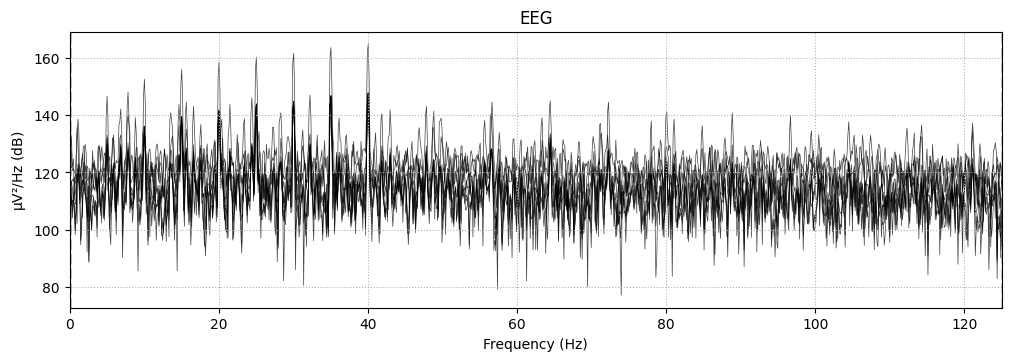

In [32]:
raw_mne_CAR.plot_psd()

# Process & Visualize data not using MNE

What we want:
1. re-reference data to common average reference (CAR)
2. bandpass data to 0.5 - 40 Hz
3. Use SVT to get rid of (potential) eye blink artifacts
4. Create PSD plot of the pre-processed data


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, welch

In [34]:
# Create a function to re-reference data to CAR
def common_average_reference(data):
    common_average = np.mean(data, axis=0) # For each channel we calculate the average across time points
    data_car = data - common_average
    return data_car

In [35]:
# Create a function to design a filter (function output b, a = filter coefficients)
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs # define nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

In [36]:
# Function to apply the filter to actual data
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order = order)
    y = lfilter(b, a, data)
    return y

In [37]:
# Function to get rid of potential eye artifacts based on data threshold
def svt(data, threshold):
    min_ = np.min(data) <= -1*threshold
    max_ = np.max(data) >= threshold
    return min_ or max_

In [38]:
# Re-reference data
data_car = common_average_reference(raw_data)

# Apply filter to data along each channel of EEG (i.e., along axis 1 of raw_data)
lowcut = 1.0
highcut = 40.0
fs = 250
filtered_data = np.apply_along_axis(butter_bandpass_filter, 1, data_car, lowcut, highcut, fs)

In [39]:
# Create a function to display PSD for each channel
def plot_psd(data, fs):
    plt.figure(figsize=(10,6))
    colors =plt.cm.jet(np.linspace(0,1,data.shape[0])) # Create jet color map

    for i, ch_data in enumerate(data):
        freqs, psd = welch(ch_data, fs, nperseg=1024) # Use scipy welch method to estimate psd for each channel data (higher nperseg = higher resolution)
        plt.semilogy(freqs, psd, color=colors[i], label=f'Channel {i+1}')
    
    plt.title('Power Spectral Density')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('power/frequency (db/Hz)')
    plt.legend()
    plt.show()

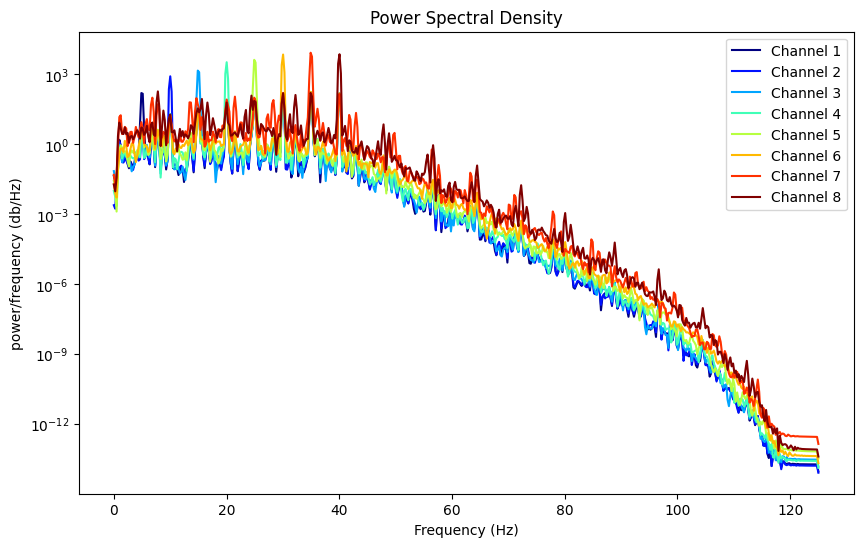

In [40]:
# Create plot
plt.close('all')
plot_psd(filtered_data,fs)